In [15]:
import numpy as np
import pandas as pd
import SERGIO.SERGIO.sergio as sergio
import re
import os
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

In [16]:
import tensorflow as tf
print("gpu available: ", tf.config.list_physical_devices('GPU'))
!pwd

gpu available:  []
/scratch/ab9738/dfdl_imputation


# Simulate Clean Data _ Steady-State Simulation

In [17]:
def parse_dataset_name(folder_name):
    pattern1 = r'De-noised_(\d+)G_(\d+)T_(\d+)cPerT_dynamics_(\d+)_DS(\d+)'
    pattern2 = r'De-noised_(\d+)G_(\d+)T_(\d+)cPerT_(\d+)_DS(\d+)'
    match_p1 = re.match(pattern1, folder_name)
    match_p2 = re.match(pattern2, folder_name)
    if match_p1:
        return {
            'number_genes': int(match_p1.group(1)),
            'number_bins': int(match_p1.group(2)),
            'number_sc': int(match_p1.group(3)),
            'dynamics': int(match_p1.group(4)),
            'dataset_id': int(match_p1.group(5)),
            "pattern": "De-noised_{number_genes}G_{number_bins}T_{number_sc}cPerT_dynamics_{dynamics}_DS{dataset_id}"
        }
    if match_p2:
        return {
            'number_genes': int(match_p2.group(1)),
            'number_bins': int(match_p2.group(2)),
            'number_sc': int(match_p2.group(3)),
            'dynamics': int(match_p2.group(4)),
            'dataset_id': int(match_p2.group(5)),
            "pattern": "De-noised_{number_genes}G_{number_bins}T_{number_sc}cPerT_{dynamics}_DS{dataset_id}"
        }
    return

def get_datasets():
    datasets = []
    for folder_name in os.listdir('./SERGIO/data_sets'):
        dataset_info = parse_dataset_name(folder_name)
        if dataset_info:
            datasets.append(dataset_info)
    return sorted(datasets, key=lambda x: x['dataset_id'])

def fstr(template):
    return eval(f'f"""{template}"""')

In [18]:
def experiment(data_info):
    sim = sergio.sergio(
        number_genes=data_info["number_genes"],
        number_bins=data_info["number_bins"], 
        number_sc=data_info["number_sc"],
        noise_params=1,
        decays=0.8, 
        sampling_state=15,
        noise_type='dpd'
    )
    # sim.build_graph(input_file_taregts ='data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Interaction_cID_6.txt',\
    #                 input_file_regs='data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Regs_cID_6.txt', shared_coop_state=2)
    number_genes = data_info["number_genes"]
    number_bins = data_info["number_bins"]
    number_sc = data_info["number_sc"]
    dynamics = data_info["dynamics"]
    dataset_id = data_info["dataset_id"]
    pattern = data_info["pattern"]
    folder_name = pattern.format(number_genes=number_genes, number_bins=number_bins, 
                                 number_sc=number_sc, dynamics=dynamics, dataset_id=dataset_id)
    input_file_targets = f'./SERGIO/data_sets/{folder_name}/Interaction_cID_{data_info["dynamics"]}.txt'
    input_file_regs = f'./SERGIO/data_sets/{folder_name}/Regs_cID_{data_info["dynamics"]}.txt'
    
    sim.build_graph(
        input_file_taregts=input_file_targets,
        input_file_regs=input_file_regs,
        shared_coop_state=2
    )
    sim.simulate()
    expr = sim.getExpressions()
    expr_clean = np.concatenate(expr, axis=1)
    return sim, expr, expr_clean

In [19]:
def save_data(dataset_id, expr_clean, expr, sim):
    print(f"DS{dataset_id}: {expr_clean.shape}")
    os.makedirs('./SERGIO/imputation_data', exist_ok=True)
    np.save(f'./SERGIO/mputation_data_temp/DS{dataset_id}_clean', expr_clean)
    np.save(f'./SERGIO./imputation_data/DS{dataset_id}_expr', expr)
    cmat_clean = sim.convert_to_UMIcounts(expr)
    cmat_clean = np.concatenate(cmat_clean, axis=1)
    np.save(f'./SERGIO/imputation_data/DS{dataset_id}_clean_counts', cmat_clean)

In [20]:
def sparse_ratio(data):
    # ndarray
    return 1 - np.count_nonzero(data) / data.size

In [21]:
datasets = get_datasets()

In [14]:
sparse_ratios = []
for dataset in tqdm(datasets):
    sim, expr, expr_clean = experiment(dataset)
    print("finished experiment")
    save_data(dataset['dataset_id'], expr_clean, expr, sim)
    print("saved data")
    sparse_ratios.append(sparse_ratio(expr_clean))
print(f"Sparse ratios: {sparse_ratios}")

: 

In [9]:
# gene_correlation = stats.pearsonr([d['number_genes'] for d in datasets], sparse_ratios)[0]
# bin_correlation = stats.pearsonr([d['number_bins'] for d in datasets], sparse_ratios)[0]
# sc_correlation = stats.pearsonr([d['number_sc'] for d in datasets], sparse_ratios)[0]
# print("Pearson correlation")
# print(f"number genes: {gene_correlation}")
# print(f"number bins: {bin_correlation}")
# print(f"number sc: {sc_correlation}")

# gene_spearman = stats.spearmanr([d['number_genes'] for d in datasets], sparse_ratios)[0]
# bin_spearman = stats.spearmanr([d['number_bins'] for d in datasets], sparse_ratios)[0]
# sc_spearman = stats.spearmanr([d['number_sc'] for d in datasets], sparse_ratios)[0]
# print("Spearson correlation")
# print(f"number genes: {gene_spearman}")
# print(f"number bins: {bin_spearman}")
# print(f"number sc: {sc_spearman}")

# Experiment

In [10]:
def get_sparsity_of_binary_ind(sim, expr, expr_clean, percentile=45):
    """
    Add outlier genes
    """
    expr_O = sim.outlier_effect(expr, outlier_prob = 0.01, mean = 5, scale = 1)

    """
    Add Library Size Effect
    """
    libFactor, expr_O_L = sim.lib_size_effect(expr_O, mean = 4.5, scale = 0.7)

    """
    Add Dropouts
    """
    binary_ind = sim.dropout_indicator(expr_O_L, shape = 8, percentile = percentile)
    expr_O_L_D = np.multiply(binary_ind, expr_O_L)

    """
    Convert to UMI count
    """
    count_matrix = sim.convert_to_UMIcounts(expr_O_L_D)

    """
    Make a 2d gene expression matrix
    """
    count_matrix = np.concatenate(count_matrix, axis = 1)
    
    np.save('./SERGIO/imputation_data/DS{dataset_id}_45', count_matrix)
    print(count_matrix.shape)
    return sparse_ratio(binary_ind)

In [15]:
def run_experiment_for_dataset(sim, expr, expr_clean, dataset_id):
    percentiles = range(1, 101, 10)
    sparsity_ratios = []

    for percentile in tqdm(percentiles):
        ratio = get_sparsity_of_binary_ind(sim, expr, expr_clean, percentile=percentile)
        sparsity_ratios.append(ratio)
    plt.figure(figsize=(10, 6))
    plt.plot(percentiles, sparsity_ratios, marker='o')
    plt.title(f'{dataset_id}: sparsity ratio vs percentile')
    plt.ylabel('Sparsity ratio')
    plt.xlabel('Percentile')
    plt.grid(True)
    plt.savefig(f"./experiments/sparsity/sparsity_ratio_plot_{dataset_id}.png")
    print(f"Dataset: {dataset['dataset_id']}")
    print(f"Minimum sparsity ratio: {min(sparsity_ratios):.4f} at percentile {percentiles[sparsity_ratios.index(min(sparsity_ratios))]}")
    print(f"Maximum sparsity ratio: {max(sparsity_ratios):.4f} at percentile {percentiles[sparsity_ratios.index(max(sparsity_ratios))]}")
    print(f"Average sparsity ratio: {sum(sparsity_ratios) / len(sparsity_ratios):.4f}")
    print()


 12%|██████████████████████▎                                                                                                                                                           | 1/8 [00:00<00:01,  3.78it/s]

Dataset: 1
Minimum sparsity ratio: 0.1001 at percentile 1
Maximum sparsity ratio: 0.8986 at percentile 91
Average sparsity ratio: 0.4529



 25%|████████████████████████████████████████████▌                                                                                                                                     | 2/8 [00:00<00:01,  4.18it/s]

Dataset: 2
Minimum sparsity ratio: 0.1267 at percentile 1
Maximum sparsity ratio: 0.8851 at percentile 91
Average sparsity ratio: 0.4646



 38%|██████████████████████████████████████████████████████████████████▊                                                                                                               | 3/8 [00:00<00:01,  4.27it/s]

Dataset: 3
Minimum sparsity ratio: 0.0990 at percentile 1
Maximum sparsity ratio: 0.8994 at percentile 91
Average sparsity ratio: 0.4685



 50%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 4/8 [00:00<00:00,  4.41it/s]

Dataset: 4
Minimum sparsity ratio: 0.1464 at percentile 1
Maximum sparsity ratio: 0.8899 at percentile 91
Average sparsity ratio: 0.4755



 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 5/8 [00:01<00:00,  4.43it/s]

Dataset: 5
Minimum sparsity ratio: 0.1249 at percentile 1
Maximum sparsity ratio: 0.8983 at percentile 91
Average sparsity ratio: 0.4773



 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 6/8 [00:01<00:00,  4.44it/s]

Dataset: 6
Minimum sparsity ratio: 0.1225 at percentile 1
Maximum sparsity ratio: 0.9001 at percentile 91
Average sparsity ratio: 0.4655



 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 7/8 [00:01<00:00,  4.48it/s]

Dataset: 7
Minimum sparsity ratio: 0.0959 at percentile 1
Maximum sparsity ratio: 0.8193 at percentile 91
Average sparsity ratio: 0.4453



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.40it/s]


Dataset: 8
Minimum sparsity ratio: 0.1523 at percentile 11
Maximum sparsity ratio: 0.8300 at percentile 91
Average sparsity ratio: 0.4558



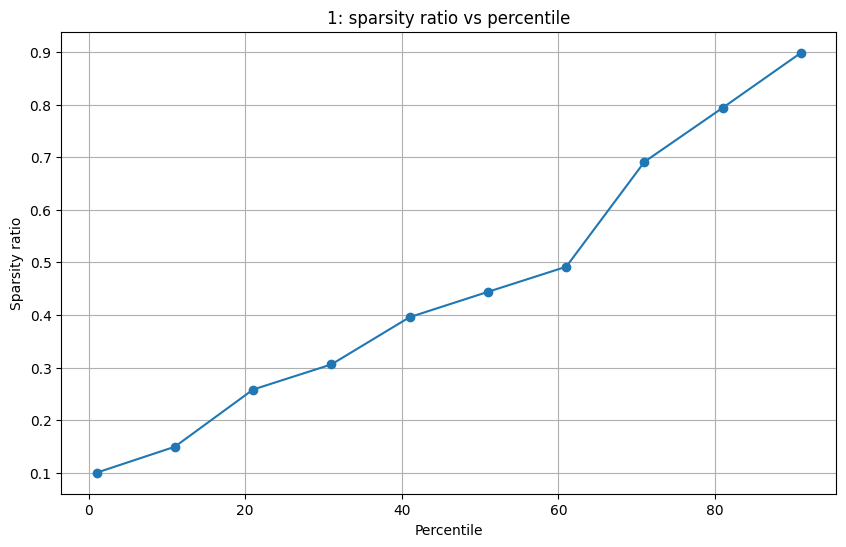

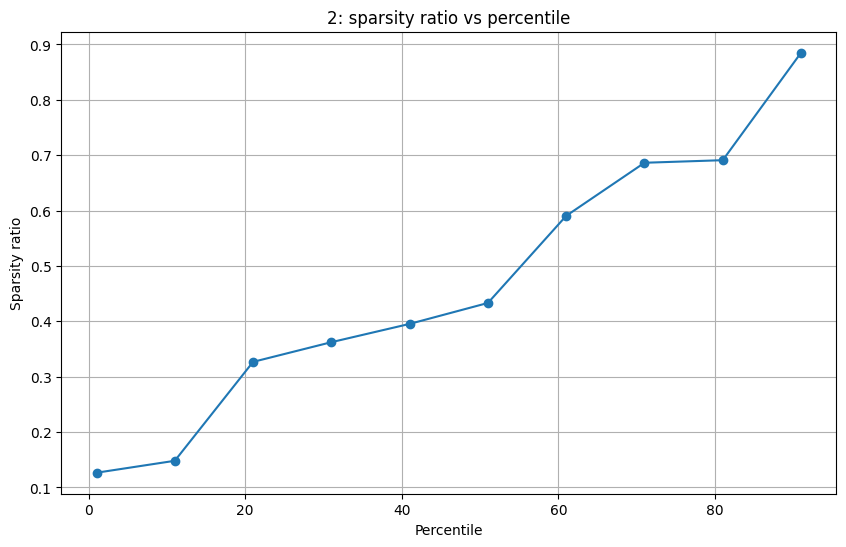

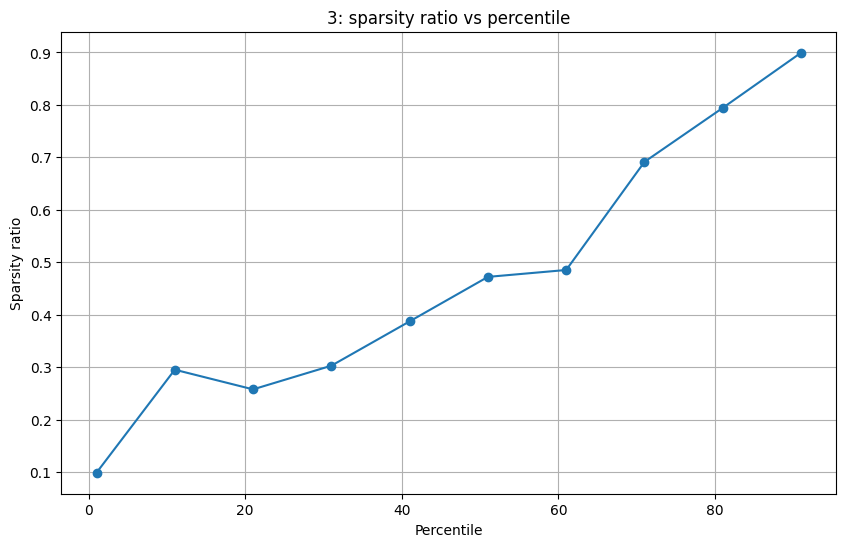

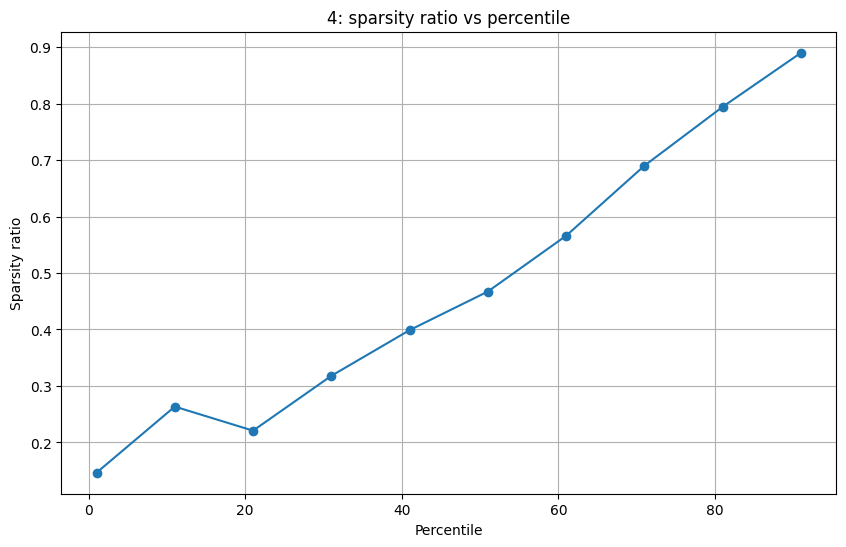

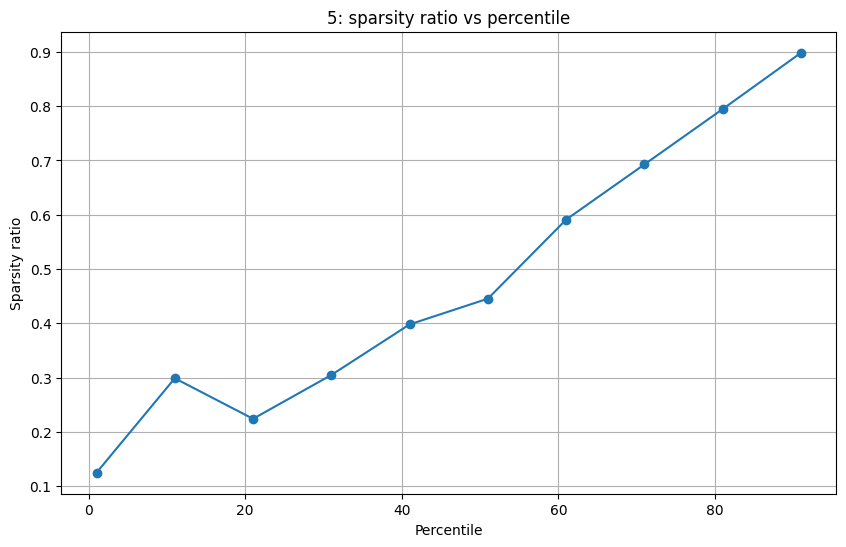

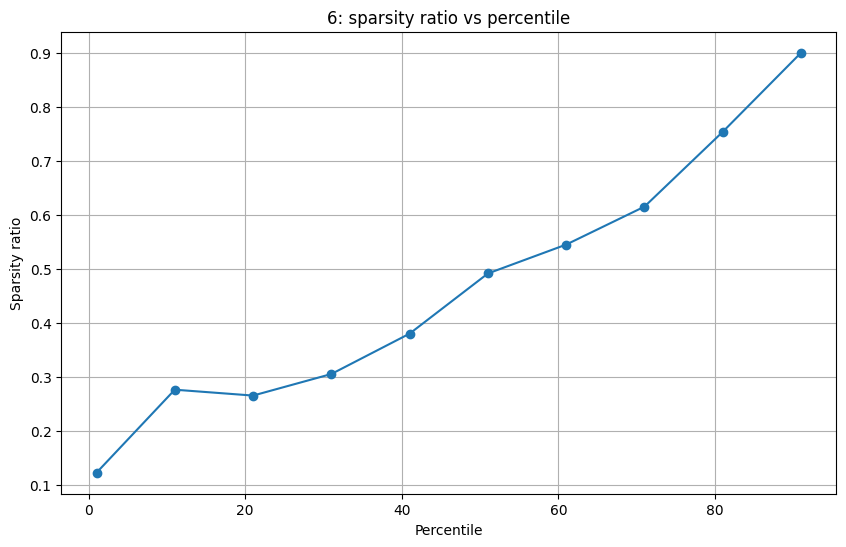

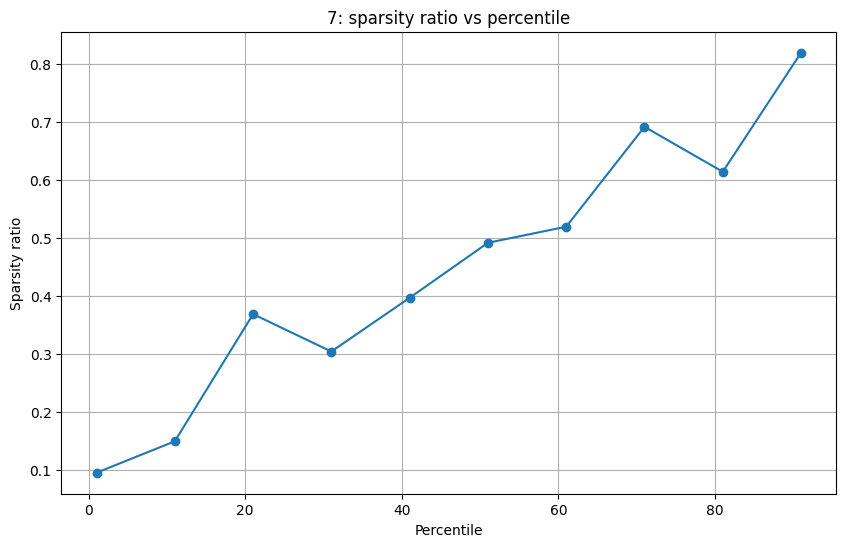

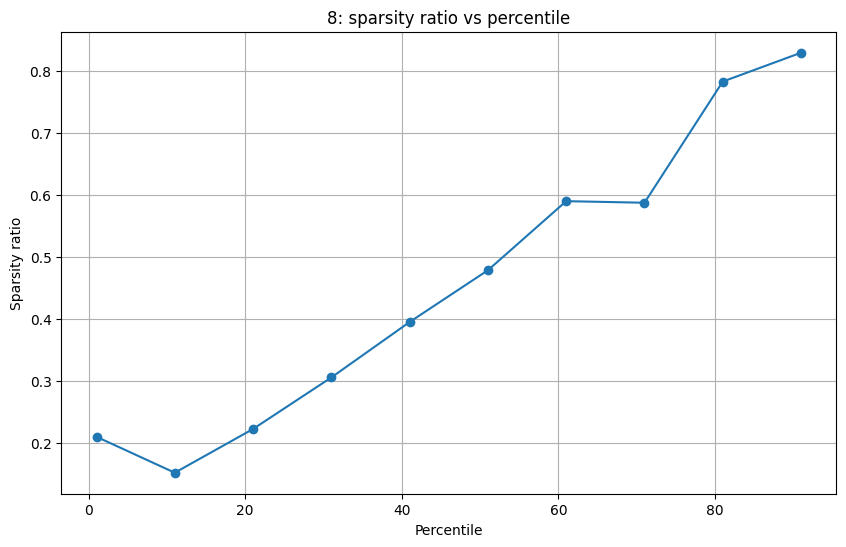

In [16]:
for dataset in tqdm(datasets):
    run_experiment_for_dataset(sim, expr, expr_clean, dataset['dataset_id'])

# Add Technical Noise _ Steady-State Simulations

In [17]:
"""
Add outlier genes
"""
expr_O = sim.outlier_effect(expr, outlier_prob = 0.01, mean = 5, scale = 1)

"""
Add Library Size Effect
"""
libFactor, expr_O_L = sim.lib_size_effect(expr_O, mean = 4.5, scale = 0.7)

"""
Add Dropouts
"""
binary_ind = sim.dropout_indicator(expr_O_L, shape = 8, percentile = 45)
expr_O_L_D = np.multiply(binary_ind, expr_O_L)

"""
Convert to UMI count
"""
count_matrix = sim.convert_to_UMIcounts(expr_O_L_D)

"""
Make a 2d gene expression matrix
"""
count_matrix = np.concatenate(count_matrix, axis = 1)

In [18]:
# np.save('imputation_data/DS6_45', count_matrix)

In [19]:
count_matrix.shape

(100, 900)

# Simulate Clean Data _ differentiation Simulation

In [ ]:
# df = pd.read_csv('data_sets/De-noised_100G_6T_300cPerT_dynamics_7_DS6/bMat_cID7.tab', sep='\t', header=None, index_col=None)
# bMat = df.values

# sim = sergio(number_genes=100, number_bins = 6, number_sc = 300, noise_params = 0.2, decays=0.8, sampling_state = 1, noise_params_splice = 0.07, noise_type='dpd', dynamics=True, bifurcation_matrix= bMat)
# sim.build_graph(input_file_taregts ='data_sets/De-noised_100G_6T_300cPerT_dynamics_7_DS6/Interaction_cID_7.txt', input_file_regs='data_sets/De-noised_100G_6T_300cPerT_dynamics_7_DS6/Regs_cID_7.txt', shared_coop_state=2)
# sim.simulate_dynamics()
# exprU, exprS = sim.getExpressions_dynamics()
# exprU_clean = np.concatenate(exprU, axis = 1)
# exprS_clean = np.concatenate(exprS, axis = 1)

# Add Technical Noise _ differentiation Simulations

In [ ]:
# """
# Add outlier genes
# """
# exprU_O, exprS_O = sim.outlier_effect_dynamics(exprU, exprS, outlier_prob = 0.01, mean = 0.8, scale = 1)

# """
# Add Library Size Effect
# """
# libFactor, exprU_O_L, exprS_O_L = sim.lib_size_effect_dynamics(exprU_O, exprS_O, mean = 4.6, scale = 0.4)

# """
# Add Dropouts
# """
# binary_indU, binary_indS = sim.dropout_indicator_dynamics(exprU_O_L, exprS_O_L, shape = 6.5, percentile = 82)
# exprU_O_L_D = np.multiply(binary_indU, exprU_O_L)
# exprS_O_L_D = np.multiply(binary_indS, exprS_O_L)

# """
# Convert to UMI count
# """
# count_matrix_U, count_matrix_S = sim.convert_to_UMIcounts_dynamics(exprU_O_L_D, exprS_O_L_D)

# """
# Make 2d spliced and unspliced expression matrices
# """
# count_matrix_U = np.concatenate(count_matrix_U, axis = 1)
# count_matrix_S = np.concatenate(count_matrix_S, axis = 1)